In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm as tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


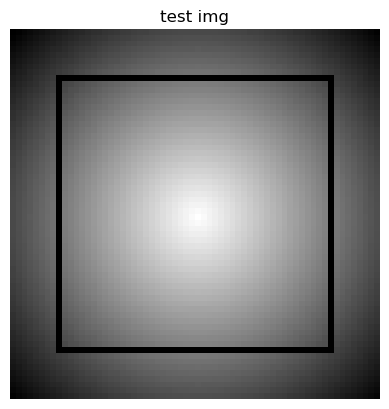

In [54]:

# Create a circular gradient image
c, h, w = 1, 64, 64
center_x, center_y = w // 2, h // 2

# Generate the circular gradient
test_img = np.zeros((c, h, w),dtype=np.float32)
radius = 90
for i in range(c):
    for y in range(h):
        for x in range(w):
            distance_to_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
            intensity = 1-distance_to_center / (radius // 2)
            test_img[i,y, x] = intensity

rect_w =48
line_w = 1
rectangle = np.zeros((rect_w,rect_w))
rectangle[line_w: -line_w, line_w :-line_w] = 1
offset = (w-rect_w)//2
for i in range(c):
    test_img[i, offset:-offset,offset:-offset]*=rectangle

# Display the image
plt.imshow(test_img[0], cmap='gray', vmin=0,vmax=1)
plt.axis('off')
plt.title("test img")
plt.show()

In [2]:
def zeros_padding(input_image, padding_size):

    channel, height, width = input_image.shape[0], input_image.shape[1], input_image.shape[2]
    padded_image = torch.zeros((channel, height + 2 * padding_size, width + 2 * padding_size))
    padded_image[:,padding_size:padding_size+height, padding_size:padding_size+width] = input_image
    return padded_image

def reflect_padding(input_image, padding_size):

    height, width = input_image.shape[0], input_image.shape[1]
    padded_image = F.pad(input_image, pad_width=padding_size, mode='reflect')
    return padded_image


def replicate_padding(input_image, padding_size):

    height, width = input_image.shape[0], input_image.shape[1]
    padded_image = F.pad(input_image, pad_width=padding_size, mode='edge')
    return padded_image


def circular_padding(input_image, padding_size):
    height, width = input_image.shape[0], input_image.shape[1]
    padded_image = torch.zeros((height + 2 * padding_size, width + 2 * padding_size))
    padded_image[padding_size:height + padding_size, padding_size:width + padding_size] = input_image
    # Wrap around the edges
    padded_image[:padding_size, padding_size:-padding_size] = input_image[-padding_size:, :]
    padded_image[-padding_size:, padding_size:-padding_size] = input_image[:padding_size, :]
    padded_image[padding_size:-padding_size, :padding_size] = input_image[:, -padding_size:]
    padded_image[padding_size:-padding_size, -padding_size:] = input_image[:, :padding_size]
    padded_image[0:padding_size, 0:padding_size] = input_image[-padding_size:, -padding_size:]
    padded_image[-padding_size:, 0:padding_size] = input_image[0:padding_size, -padding_size:]
    padded_image[0:padding_size, -padding_size:] = input_image[-padding_size:, 0:padding_size]
    padded_image[-padding_size:, -padding_size:] = input_image[0:padding_size, 0:padding_size]
    return padded_image




TypeError: can't assign a numpy.ndarray to a torch.FloatTensor

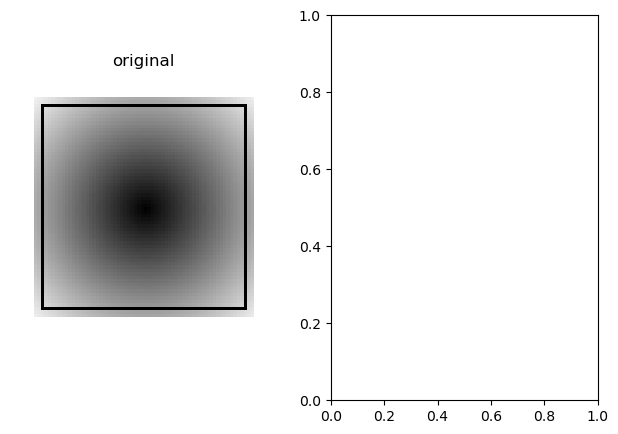

In [148]:

padding_size = 7  # Example: 1 pixel padding
c, h, w = test_img.shape
plt.figure(figsize=(20, 5))
plt.subplot(1,5,1)

padded_image = np.ones((c, h + 2 * padding_size, w + 2 * padding_size))
padded_image[:,padding_size:-padding_size, padding_size:-padding_size] = test_img

plt.imshow(padded_image[0], cmap='gray', vmin=0,vmax=1)
plt.title('original')
plt.axis('off')

plt.subplot(1,5,2)
padded_zeros_image = zeros_padding(test_img, padding_size)
plt.imshow(padded_zeros_image[0], cmap='gray', vmin=0,vmax=1)
plt.title('zero padding')
plt.axis('off')

plt.subplot(1,5,3)
padded_reflect_image = reflect_padding(test_img, padding_size)
print("Padded image shape (reflect padding):", padded_reflect_image.shape)
plt.imshow(padded_reflect_image[0], cmap='gray', vmin=0,vmax=1)
plt.title('reflect padding')
plt.axis('off')

plt.subplot(1,5,4)
padded_replicate_image = replicate_padding(test_img, padding_size)
print("Padded image shape (replicate padding):", padded_replicate_image.shape)
plt.imshow(padded_replicate_image[0], cmap='gray', vmin=0,vmax=1)
plt.title('replicate padding')
plt.axis('off')

plt.subplot(1,5,5)
padded_circular_image = circular_padding(test_img, padding_size)
print("Padded image shape (circular padding):", padded_circular_image.shape)
plt.imshow(padded_circular_image[0], cmap='gray', vmin=0,vmax=1)
plt.title('circular padding')
plt.axis('off')

plt.show()

In [3]:
def sigmoid(x):
  return 1/(1+np.exp(-x))
def relu(x):
   return np.maximum(0,x)

In [4]:
def activate(X):
  return relu(X)

In [49]:
# different kernels
sharpening_kernel_7x7 = torch.tensor([[[[-1,-1,-1,-1,-1,-1,-1],
                                        [-1,-1,-1,-1,-1,-1,-1],
                                        [-1,-1,-1,-1,-1,-1,-1],
                                        [-1,-1,-1,49,-1,-1,-1],
                                        [-1,-1,-1,-1,-1,-1,-1],
                                        [-1,-1,-1,-1,-1,-1,-1],
                                        [-1,-1,-1,-1,-1,-1,-1]]]],dtype= torch.float32)

# Example of a 3x3 edge detection kernel
laplacian_kernel = np.array([[0, 1, 0],
                [1, -4, 1],
                [0, 1, 0]])

# Example of a 3x3 blurring kernel
sobelx_kernel = np.array([[-1, 0, 1],
              [-2, 0, 2],
              [-1, 0, 1]])
mean_kernel = np.array([[1/9, 1/9, 1/9],
                [1/9, 1/9, 1/9],
                [1/9, 1/9, 1/9]])

def create_gaussian_kernel(size=7, sigma=1.0):
    kernel = np.zeros((size, size),dtype=np.float32)
    center = size // 2

    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))

    kernel /= np.sum(kernel)
    return kernel

gaussian_kernel = create_gaussian_kernel(size=7, sigma=3.0)
gaussian_kernel=torch.from_numpy(gaussian_kernel).unsqueeze(0).unsqueeze(0)

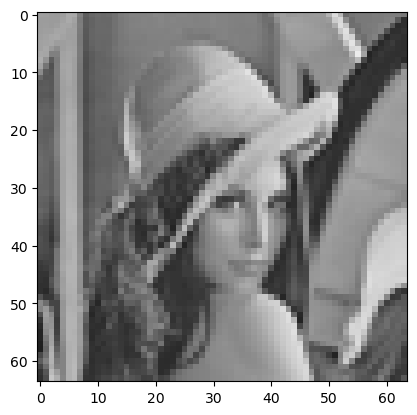

In [60]:
#checkerboard image
image_path = "lena.jpg"
image_pil = Image.open(image_path)
image_pil=image_pil.resize((64, 64))
test_img = np.array(image_pil.convert('RGB'),dtype=np.float32).mean(axis=2)
test_img=test_img /255

plt.imshow(test_img, cmap='gray',vmin=0, vmax=1)

In [52]:
class StdConv2d(nn.Conv2d):
    def forward(self, input, kernel=None):
            if kernel is None:
                w = self.weight
            else :
                w = kernel
            # plt.figure(figsize=(10, 5))
            # plt.subplot(1,2,1)
            # plt.imshow(w.squeeze().detach().numpy(),cmap='gray',vmin=0, vmax=1)
            # plt.subplot(1,2,2)
            w /= w.sum()
            # print(w.max(),w.min())
            # print(v, m)
            
            # plt.imshow(w.squeeze().detach().numpy(),cmap='gray',vmin=0, vmax=1)
            return F.conv2d(input, w)
class PartialConv2d(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super(PartialConv2d, self).__init__(*args, **kwargs)
        self.maskconv = StdConv2d(1,1,7)
        self.conv = StdConv2d(1,1,7)
    def forward(self, input, mask, kernel = None):
        if kernel is None:
            w = self.weight
        else :
            w = kernel
        dummy_krnl = torch.ones_like(w)
        maskweight = self.maskconv(mask,dummy_krnl)
        factor_map = dummy_krnl.sum()/maskweight
        output = self.conv(input, w)
        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5),dpi=80 )
        ax[0].imshow(w.squeeze().detach().numpy(),cmap='gray',vmin=w.min(), vmax=w.max())
        ax[1].imshow(factor_map.squeeze().detach().numpy(),cmap='gray',vmin=0, vmax=factor_map.max())
        ax[2].imshow(output.squeeze().detach().numpy(),cmap='gray',vmin=0, vmax=1)
        output*= factor_map
        ax[3].imshow(output.squeeze().detach().numpy(),cmap='gray',vmin=0, vmax=1)
        return output

torch.Size([1, 70, 70]) torch.Size([1, 64, 64]) torch.Size([1, 64, 64])


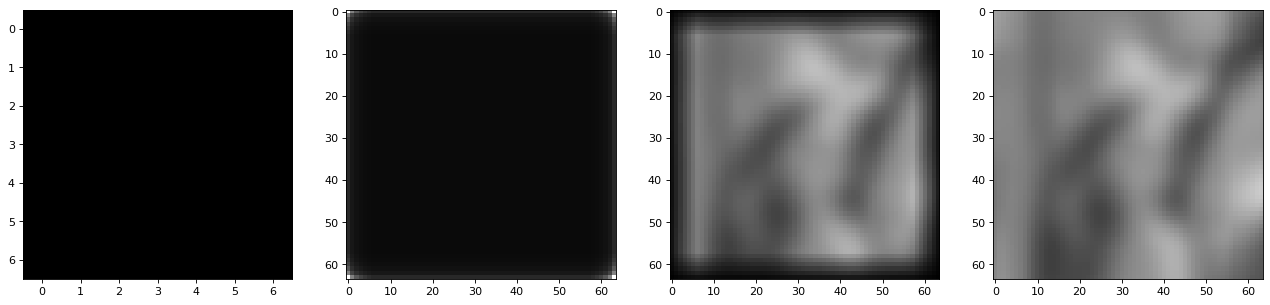

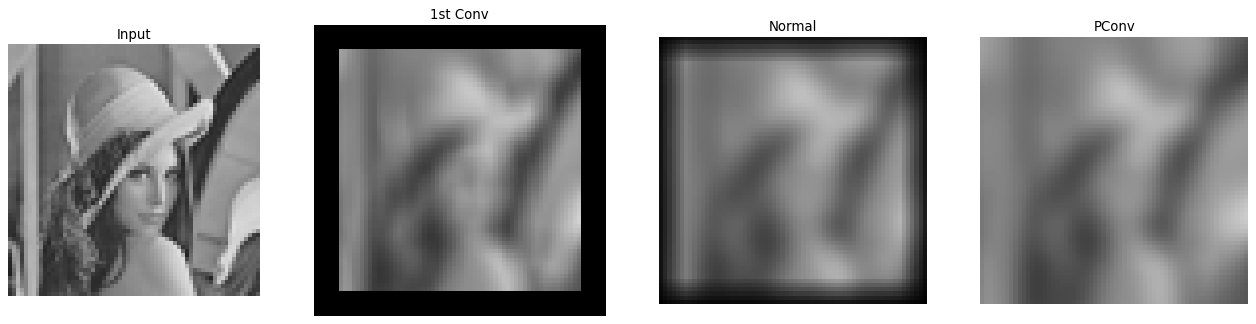

In [71]:

class SimpleNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = StdConv2d(1,1,3)
        self.conv2 = PartialConv2d(1,1,7)
        self.kernel1 = torch.ones((1,1,7,7))
        self.kernel2 = torch.ones((1,1,7,7))
        # self.kernel1 = gaussian_kernel
        # self.kernel2 = gaussian_kernel
        # self.kernel1 = sharpening_kernel_7x7
        # self.kernel2 = sharpening_kernel_7x7
        # self.kernel1 = torch.randn((1,1,7,7))
        # self.kernel2 = torch.randn((1,1,7,7))
        self.conv2_ =StdConv2d(1,1,7)

        
    def forward(self,x):
        
        x=self.conv1(x, self.kernel1)
        # print(x.shape)
        # x-= x.min()
        # x/= x.max()
        pad_size = 6
        pad_x = zeros_padding(x,pad_size)
        
        ph, pw = pad_x.shape[1], pad_x.shape[2]
        mask = torch.zeros((1,ph,pw))
        mask[:,pad_size:-pad_size,pad_size:-pad_size] =1

        # print(pad_x.unsqueeze(0).shape, mask.shape)
        x1 = self.conv2(pad_x, mask, self.kernel2)
        # x1-= x1.min()
        # x1/= x1.max()
        x2 = self.conv2_(pad_x, self.kernel2)
        # x2-= x2.min()
        # x2/= x2.max()
        return pad_x , x1, x2
        
model = SimpleNetwork()
input = torch.from_numpy(test_img)
if len(input.shape) ==2 : #2d array 
    input = input.unsqueeze(0)
# input = torch.ones((1,64,64))
# pad_x, out_pconv, out = model(torch.from_numpy(test_img))#.unsqueeze(0))
pad_x, out_pconv, out = model(input)
print(pad_x.shape, out.shape, out_pconv.shape)
# print(out_pconv.max(), out_pconv.min())
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5),dpi=80 , gridspec_kw={"width_ratios":[64,74,68,68]})
ax[1].set_title('1st Conv')
ax[1].axis('off')
ax[1].imshow(pad_x.squeeze().detach().numpy(),cmap='gray',vmin=0, vmax=1)
ax[0].set_title('Input')
ax[0].axis('off')
ax[0].imshow(input.squeeze(),cmap='gray',vmin=0, vmax=1)

ax[2].set_title('Normal')
ax[2].axis('off')
ax[2].imshow(out.squeeze().detach().numpy(),cmap='gray',vmin=0, vmax=1)
ax[3].set_title('PConv')
ax[3].axis('off')
ax[3].imshow(out_pconv.squeeze().detach().numpy(),cmap='gray',vmin=0, vmax=1)

In [155]:
# Example usage
# input_image = np.ones((256, 256))/2  # 16x16 image
gaussian_kernel = mean_kernel  # 3x3 kernel
padding_pixels = 1  # Example: 1 pixel padding


input_partial = [test_img]
input_zero = [test_img]
input_reflect = [test_img]
input_replicate = [test_img]
input_circular = [test_img]

input_partial.append(custom_convolution(input_partial[-1], gaussian_kernel, 0))
input_zero.append(custom_convolution(input_zero[-1], gaussian_kernel, 0))
input_reflect.append(custom_convolution(input_reflect[-1], gaussian_kernel, 0))
input_replicate.append(custom_convolution(input_replicate[-1], gaussian_kernel, 0))
input_circular.append(custom_convolution(input_circular[-1], gaussian_kernel, 0))
input_partial[-1]= activate(input_partial[-1])
input_zero[-1]= activate(input_zero[-1])
input_reflect[-1]= activate(input_reflect[-1])
input_replicate[-1]= activate(input_replicate[-1])
input_circular[-1]= activate(input_circular[-1])

plt.figure(figsize=(15, 5))

plt.subplot(2,6,1)
plt.title('Original')
plt.imshow(test_img, cmap='gray',vmin=0, vmax=1)
plt.axis('off')

input_partial.append(custom_convolution(input_partial[-1], gaussian_kernel, padding_pixels, padding_mode='zero',partial_enable = True))
plt.subplot(2,6,2)
plt.title('Partial Conv')
plt.imshow(input_partial[-1], cmap='gray',vmin=0, vmax=1)
plt.axis('off')

input_zero.append(custom_convolution(input_zero[-1], gaussian_kernel, padding_pixels, padding_mode='zero',partial_enable = False))
plt.subplot(2,6,3)
plt.title('Zero Padding')
plt.imshow(input_zero[-1], cmap='gray',vmin=0, vmax=1)
plt.axis('off')

input_reflect.append(custom_convolution(input_reflect[-1], gaussian_kernel, padding_pixels, padding_mode='reflect',partial_enable = False))
plt.subplot(2,6,4)
plt.title('Reflect Padding')
plt.imshow(input_reflect[-1], cmap='gray',vmin=0, vmax=1)
plt.axis('off')

input_replicate.append(custom_convolution(input_replicate[-1], gaussian_kernel, padding_pixels, padding_mode='replicate',partial_enable = False))
plt.subplot(2,6,5)
plt.title('Replicate Padding')
plt.imshow(input_replicate[-1], cmap='gray',vmin=0, vmax=1)
plt.axis('off')

input_circular.append(custom_convolution(input_circular[-1], gaussian_kernel, padding_pixels, padding_mode='circular',partial_enable = False))
plt.subplot(2,6,6)
plt.title('Circular Padding')
plt.imshow(input_circular[-1], cmap='gray',vmin=0, vmax=1)
plt.axis('off')



for i in tqdm(range(10)):
  input_partial.append(custom_convolution(input_partial[-1], gaussian_kernel, padding_pixels, padding_mode='zero',partial_enable = True))
  input_zero.append(custom_convolution(input_zero[-1], gaussian_kernel, padding_pixels, padding_mode='zero',partial_enable = False))
  input_reflect.append(custom_convolution(input_reflect[-1], gaussian_kernel, padding_pixels, padding_mode='reflect',partial_enable = False))
  input_replicate.append(custom_convolution(input_replicate[-1], gaussian_kernel, padding_pixels, padding_mode='replicate',partial_enable = False))
  input_circular.append(custom_convolution(input_circular[-1], gaussian_kernel, padding_pixels, padding_mode='circular',partial_enable = False))
  input_partial[-1]= activate(input_partial[-1])
  input_zero[-1]= activate(input_zero[-1])
  input_reflect[-1]= activate(input_reflect[-1])
  input_replicate[-1]= activate(input_replicate[-1])
  input_circular[-1]= activate(input_circular[-1])

print(input_partial[-1].shape)

# plt.subplot(2,6,7)
# plt.title('Original')
# plt.imshow(test_img, cmap='gray',vmin=0, vmax=1)
# plt.axis('off')

plt.subplot(2,6,8)
plt.imshow(input_partial[-1], cmap='gray',vmin=0, vmax=1)
plt.axis('off')
plt.subplot(2,6,9)
plt.imshow(input_zero[-1], cmap='gray',vmin=0, vmax=1)
plt.axis('off')
plt.subplot(2,6,10)
plt.imshow(input_reflect[-1], cmap='gray',vmin=0, vmax=1)
plt.axis('off')
plt.subplot(2,6,11)
plt.imshow(input_replicate[-1], cmap='gray',vmin=0, vmax=1)
plt.axis('off')
plt.subplot(2,6,12)
plt.imshow(input_circular[-1], cmap='gray',vmin=0, vmax=1)
plt.axis('off')
plt.show()

TypeError: 'int' object is not subscriptable

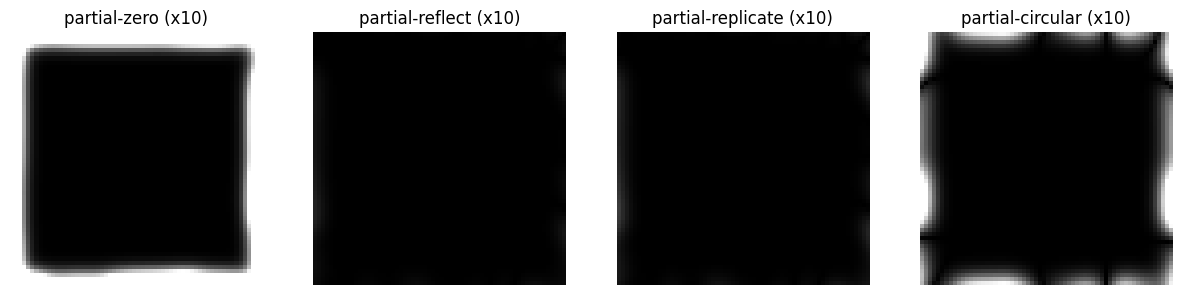

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1,4,1)
plt.imshow(np.abs(input_partial[-1]-input_zero[-1])*10, cmap='gray',vmin=0, vmax=1)
plt.title('partial-zero (x10)')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(np.abs(input_partial[-1]-input_reflect[-1])*10, cmap='gray',vmin=0, vmax=1)
plt.title('partial-reflect (x10)')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(np.abs(input_partial[-1]-input_replicate[-1])*10, cmap='gray',vmin=0, vmax=1)
plt.title('partial-replicate (x10)')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(np.abs(input_partial[-1]-input_circular[-1])*10, cmap='gray',vmin=0, vmax=1)
plt.title('partial-circular (x10)')
plt.axis('off')

plt.show()

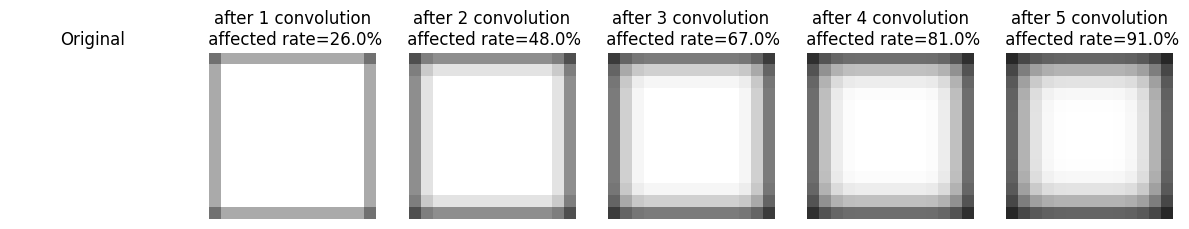

In [ ]:
test_img = np.ones((14,14))

plt.figure(figsize=(15, 5))

plt.subplot(1,6,1)
plt.title('Original')
plt.imshow(test_img, cmap='gray',vmin=0, vmax=1)
plt.axis('off')

for i in range(5):
  output = custom_convolution(test_img, gaussian_kernel, padding_pixels, padding_mode='zero',partial_enable = False)
  plt.subplot(1,6,i+2)
  non_one_rate = np.sum(output != 1)/output.shape[0]**2
  plt.title(f'after {i+1} convolution\n affected rate={non_one_rate*100//1}%')
  plt.imshow(output, cmap='gray',vmin=0, vmax=1)
  plt.axis('off')
  test_img = output

plt.show()

In [ ]:
#image of box
test_img = np.zeros((256,256))
test_img[1:255,1:255] = 1